In [5]:
# import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

In [6]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
import pandas as pd
df = pd.read_csv('dataset_sheets\Datahunters complete upload 23-01-22.csv').fillna('')
df['id'] = df.index
df = df[['id','post_title','data_categories']]
df['post_title'] = df['post_title'].apply(lambda x:x.lower())

df['data_categories'] = df['data_categories'].apply(lambda x: x.lower().split(','))

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# print(df['data_categories'])
x = list(df['post_title'])
y = list(df['data_categories'])
# y
len(y)

381

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
 
yt = mlb.fit_transform(y)
yt.shape

(381, 80)

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x, yt, test_size=0.1, random_state=RANDOM_SEED,shuffle=True)
x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

In [12]:
len(x_tr) ,len(x_val), len(x_test)

(273, 69, 39)

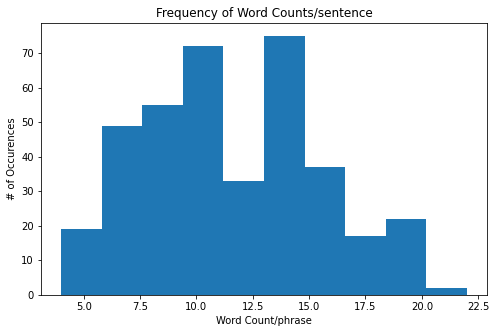

In [13]:
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
questions = x
word_cnt = [len(quest.split()) for quest in questions]
# Plot the distribution
plt.figure(figsize=[8,5])
plt.hist(word_cnt, bins = 10)
plt.xlabel('Word Count/phrase')
plt.ylabel('# of Occurences')
plt.title("Frequency of Word Counts/sentence")
plt.show()

In [14]:
class QTagDataset (Dataset):
    def __init__(self,quest,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }

In [15]:
class QTagDataModule (pl.LightningDataModule):
    
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=16,max_token_len=200):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self):
        self.train_dataset = QTagDataset(quest=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.val_dataset  = QTagDataset(quest=self.val_text,tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset  = QTagDataset(quest=self.test_text,tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset,batch_size = self.batch_size,shuffle = True , num_workers=2)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= 16)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= 16)

In [16]:
BERT_MODEL_NAME = "bert-base-cased" # we will use the BERT base model(the smaller one)
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [17]:
for question in questions:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = Bert_tokenizer.encode(question, add_special_tokens=True)

In [17]:
# Initialize the parameters that will be use for training
N_EPOCHS = 12
BATCH_SIZE = 16
MAX_LEN = 30
LR = 2e-05

In [18]:
QTdata_module = QTagDataModule(x_tr,y_tr,x_val,y_val,x_test,y_test,Bert_tokenizer,BATCH_SIZE,MAX_LEN)
QTdata_module.setup()

In [19]:
class QTagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, n_classes=80, steps_per_epoch=None, n_epochs=3, lr=2e-5 ):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes) # outputs = number of labels
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids = input_ids ,attention_mask = attn_mask)
        output = self.classifier(output.pooler_output)
                
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch//3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]

In [20]:
steps_per_epoch = len(x_tr)//BATCH_SIZE
model = QTagClassifier(n_classes=80, steps_per_epoch=steps_per_epoch,n_epochs=N_EPOCHS,lr=LR)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
#Initialize Pytorch Lightning callback for Model checkpointing

# saves a file like: input/QTag-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',# monitored quantity
    filename='QTag-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
)

In [22]:
trainer = pl.Trainer(max_epochs = N_EPOCHS , gpus = 0, callbacks=[checkpoint_callback],progress_bar_refresh_rate = 10)

C:\Users\leozi\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [23]:
trainer.fit(model, QTdata_module)

C:\Users\leozi\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
C:\Users\leozi\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 108 M 
1 | classifier | Linear            | 61.5 K
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total 

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\leozi\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\leozi\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\leozi\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s] 